In [ ]:
import time

import mediapipe as mp
import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, InputLayer
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import pandas as pd
import numpy as np
import os
import string
import pickle
import matplotlib.pyplot as plt

import random


global base_dir
base_dir=os.getcwd()


    
    
def index_images():
    global mid_paths
    mid_paths=[]
    for chara in string.ascii_uppercase:
        mid_paths.append(chara+'')
    mid_paths.append('space')
    mid_paths.remove('J') 

index_images()


#SETUP FOR get_landmarks(). RUN FIRST

def setup_hands(confidence=0.75):
    global mpHands,hands,mpDraw
    mpHands = mp.solutions.hands
    hands = mpHands.Hands(max_num_hands=1, min_detection_confidence=confidence)
    mpDraw = mp.solutions.drawing_utils

setup_hands()


def get_landmarks(image, draw=False, err=False):
    framergb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    x , y, c = image.shape

    # Get hand landmark prediction
    result = hands.process(framergb)
    # post process the result
    if result.multi_hand_landmarks:
        landmarks = []           
        for handslms in result.multi_hand_landmarks:
            for lm in handslms.landmark:
                # print(id, lm)
                lmx = int(lm.x * x)
                lmy = int(lm.y * y)
                landmarks.append([lmx, lmy])
            if draw:
                # Drawing landmarks on frames
                mpDraw.draw_landmarks(image, handslms, mpHands.HAND_CONNECTIONS)
        return(landmarks)
    else:
        if err:
            print('Error: Hand not detected')
        return('Error: Hand not detected')
        

        
# Used to scale all landmarks to to palm of the hand


def distance2d(a,b):
    xd=a[0]-b[0]
    yd=a[1]-b[1]
    return((xd**2+yd**2)**0.5)



# Scale all landmarks to the size of the palm of the hand
# Accepts a Pandas row
def reg_lm(landmarks):
    #print(landmarks)
    out_row=landmarks.copy()
    p0,p5,p17=landmarks[0],landmarks[5],landmarks[17],
    p5_p17_mp=[(landmarks[5][0]+landmarks[17][0])/2,(landmarks[5][1]+landmarks[17][1])/2]
    palmh=distance2d(p0,p5_p17_mp)
    palmw=distance2d(p5,p17)
    #print(palmh,palmw)
    try:
        for i in range(21):
            x_out=out_row[i][0]-p0[0]
            y_out=out_row[i][1]-p0[1]
            if float(x_out)!=0.0:
                x_out/=palmw
            if float(y_out)!=0.0:
                y_out/=palmh
            out_row.at[i]=[x_out,-1*y_out]
    except:
        #print(palmw,palmh,end=',')
        pass
    #out_row.iloc[0][0:21]
    return(out_row)


def to_sk_flat(image):
    lmks=get_landmarks(image)
    if type(lmks)==str:
        return('NA')
    lmks=pd.DataFrame([lmks]).iloc[0]
    lmks=reg_lm(lmks)
    lmks=np.array(lmks.to_list()).flatten()
    return(lmks)
    
    
    
def predict_image(model,img,letter=False):
    lmks=to_sk_flat(img)
    if type(lmks)==str:
        return('Hand not detected')
    test_batch=np.zeros((32,42))
    test_batch[0]=lmks
    pred_matrix=model.predict(test_batch)[0]
    pred=pred_matrix.argmax()
    
    if letter:
        return(mid_paths[pred],pred_matrix[pred])
    else:
        return(pred,pred_matrix[pred])




LMNN = Sequential()
LMNN.add(InputLayer(input_shape=(42)))
LMNN.add(Dense(96, activation='relu'))
LMNN.add(Dense(256, activation='relu'))
LMNN.add(Dense(128, activation='relu'))
LMNN.add(Dense(64, activation='relu'))
LMNN.add(Dense(26, activation='softmax'))
LMNN.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)
#LMNN.summary()

LMNN=tf.keras.models.load_model(base_dir)


print('Press X to stop image capture.')



capture = cv2.VideoCapture(1)

# Hold the background frame for background subtraction.
background = None
# Hold the hand's data so all its details are in one place.
hand = None
# Variables to count how many frames have passed and to set the size of the window.
frames_elapsed = 0
FRAME_HEIGHT = 720
FRAME_WIDTH = 1280
# Humans come in a ton of beautiful shades and colors.
# Try editing these if your program has trouble recognizing your skin tone.
CALIBRATION_TIME = 30
BG_WEIGHT = 0.5
OBJ_THRESHOLD = 18

i=0

sq_size=512
sqh_off=500
sqv_off=500

while True:
    i+=1
    
    # Store the frame from the video capture and resize it to the desired window size.
    ret, frame = capture.read()
    frame = frame[sqh_off:sqh_off+sq_size, sqv_off:sqv_off+sq_size]
    #frame = cv2.resize(frame, (FRAME_WIDTH, FRAME_HEIGHT))
    frame_copy=frame.copy()
    p=predict_image(LMNN,frame_copy, True)
    text_to_draw=str(p[0]+str(p[1]))
    
    get_landmarks(frame, True)
    frame=cv2.flip(frame,1)
    cv2.putText(frame,text_to_draw,(25,25),0,1,0)
    cv2.imshow("Camera Input", frame)


    # Check if user wants to exit.
    if (cv2.waitKey(1) & 0xFF == ord('x')):
        break

# When we exit the loop, we have to stop the capture too.
# capture.release()
# cv2.destroyAllWindows()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
2021-12-02 16:35:16.634315: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-02 16:35:16.636565: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Press X to stop image capture.


2021-12-02 16:35:17.876437: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


In [15]:
import matplotlib.pyplot as plt
import cv2

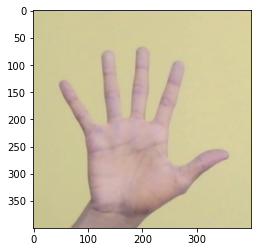

In [10]:
frame=cv2.imread('WD_I.png')
plt.imshow(frame[:,::-1])

In [ ]:
frame=frame[]